###  CIFAR-10 데이터를 이용해 CNN 설계하기

####  Module Import

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

#### 장비 확인, 하이퍼파라미터 설정

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using PyTorch version: {torch.__version__}, device: {device}')

batch_size = 64
learning_rate = 0.001
epochs = 20

Using PyTorch version: 1.8.0, device: cuda


** Data Augmentation 데이터 증강 **

복잡한 모델을 만들기 위해서 다량의 데이터가 필요합니다. 하지만 우리가 갖고 있는 데이터는 한정적입니다.  
그래서 이를 보완하기 위한 방법이 Data Augmentation입니다.  
데이터를 임의로 변형해 데이터의 수를 늘려 다양한 Feature를 뽑는 방법을 'Data Augmentation'이라 합니다.  
이미지를 돌리거나 뒤집는 것만 해도 컴퓨터가 보기엔 전혀 다른 수치이기 때문에 데이터 수를 늘리는 효과를 가져온다고 할 수 있습니다. 

   - Flip: 반전을 의미합니다. 이미지를 랜덤하게 좌우 또는 상하 반전시키는 Random Flip 입니다.
   - Rotation: 이미지를 회전시키는 것입니다.
   - Crop: 이미지의 일정 부분을 잘라 사용하는 기법입니다.
   - Scaling: 이미지를 확대 또는 축소시키는 기법입니다.
   - Cutout: 이미지의 일부를 사각형 모양으로 검은색을 칠하는 기법입니다. 숫자로는 0을 채워 넣는 것이라 생각할 수 있습니다. 일종의 Input 데이터에 대해 Dropout을 적용한 기법이라 이해하면 됩니다.
   - Cutmix: 두 이미지를 합쳐놓고 이미지의 Label를 학습시킬 대 각각의 이미지가 차지하는 비율만큼 학습시키는 방법입니다.   
         ->Cutout과 Cutmix 모두 일반적인 이미지 분류에서 Data Augmentation보다 성능이 뛰어나다는 것이 논문을 통해 밝혀졌습니다.

Ex)
```python
mnist_train = dset.MNIST("./", train=True, download=True, 
                         transform = transforms.Compose([
                             transforms.Resize(64),                          # 원래 32x32인 이미지를 64x64로 늘립니다.
                             transforms.CenterCrop(64),                      # 중앙 64x64를 뽑아냅니다.
                             transforms.RandomHorizontalFlip(),              # 랜덤하게 좌우반전 합니다.
                             transforms.Lambda(lambda x: x.rotate(90)),      # 람다함수를 이용해 90도 회전해줍니다.
                             transforms.ToTensor(),                          # 이미지를 텐서로 변형합니다.
                         ]))
```

#### CIFAR10 데이터 다운로드(Train set, Test set 분리하기)

In [4]:
train_dataset = datasets.CIFAR10(root = './data/CIFAR_10', train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = './data/CIFAR_10', train = False, download = True, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


####  데이터 확인하기 (1)

In [5]:
for (X_train, y_train) in train_loader:
    print(f'X_train: {X_train.size()}, type: {X_train.type()}')
    print(f'y_train: {y_train.size()}, type: {y_train.type()}')
    break

X_train: torch.Size([64, 3, 32, 32]), type: torch.FloatTensor
y_train: torch.Size([64]), type: torch.LongTensor


#### 데이터 확인하기 (2)

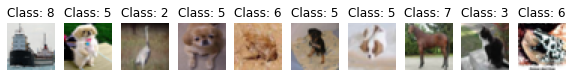

In [6]:
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1) # 1 by 10의 행렬에다가 그림을 순서대로 그릴것, i+1은 그 중 어느 열인지를 나타냄.
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title(f'Class: {str(y_train[i].item())}')

#### Convolutional Neural Network(CNN) 모델 설계하기

In [132]:
nn.Conv2d?

# nn.Conv2d(
#     in_channels,
#     out_channels,
#     kernel_size,
#     stride=1,
#     padding=0,
#     dilation=1,
#     groups=1,
#     bias=True,
#     padding_mode='zeros',
# )

In [133]:
nn.MaxPool2d?

# nn.MaxPool2d(
#     kernel_size,
#     stride=None,
#     padding=0,
#     dilation=1,
#     return_indices=False,
#     ceil_mode=False,
# )

In [68]:
# 예시1
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
    
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.maxpool(out)
        out = F.relu(self.conv2(out))
        out = self.maxpool(out)
        out = out.view(batch_size, -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [76]:
# 예시2
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)        
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(16 * 8 * 8, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
        
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

In [119]:
# 예시3
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2)        
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(32 * 4 * 4, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
        
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.conv_layer3(out)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

In [6]:
# 예시4
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            #nn.Dropout2d(0.2), # 오버피팅하지 않는 상태에서 드롭아웃을 넣으면 오히려 학습이 잘 안됨.
            nn.MaxPool2d(2)        
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.Dropout2d(0.2),
            nn.MaxPool2d(2)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.Dropout2d(0.2),
            nn.MaxPool2d(2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(32 * 4 * 4, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
        
        # initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
        
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.conv_layer3(out)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

In [9]:
# 예시5
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            #nn.MaxPool2d(2)
            nn.Conv2d(8, 8, kernel_size=3, padding=1, stride=2)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.MaxPool2d(2)
            nn.Conv2d(16, 16, kernel_size=3, padding=1, stride=2)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.MaxPool2d(2)
            nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(32 * 4 * 4, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
        
        # initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
        
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.conv_layer3(out)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

#### 모델이 잘 작동하는지 테스트

In [10]:
model = CNN()

temp_images = X_train
test_prediction = model(temp_images)
print(test_prediction.shape)

torch.Size([64, 10])


#### lr_scheduler
  - 학습률을 점차 떨어뜨리는 방법을 학습률 부식이라고 함.
  - LR(Learning Rate) Scheduler는 미리 지정한 횟수의 epoch이 지날 때마다 lr을 감소(decay)시켜준다.
  - 이는 학습 초기에는 빠르게 학습을 진행시키다가 minimum 근처에 다다른 것 같으면 lr을 줄여서 더 최적점을 잘 찾아갈 수 있게 해주는 것이다.


lr Scheduler의 종류:

º optim.lr_scheduler.LambdaLR    # lambda 함수를 하나 받아 그 함수의 결과를 lr로 설정한다.    
º optim.lr_scheduler.StepLR: 특정 step마다 lr을 gamma 비율만큼 감소시킨다.

       scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma= 0.99)   
º optim.lr_scheduler.MultiStepLR  # StepLR과 비슷한데 매 step마다가 아닌 지정된 epoch에만 gamma 비율로 감소시킨다, step_size를 milestones 인수에 리스트로 받아서 원하는 지점마다 학습률을 감소시킴  

       scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[10,30,80], gamma= 0.1)  
º optim.lr_scheduler.ExponentialLR# 매 에폭마다 학습률에 gamma를 곱해 lr을 지수함수적으로 감소시킨다.  

       scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99).  
º optim.lr_scheduler.CosineAnnealingLR    # lr을 cosine 함수의 형태처럼 변화시킨다. lr이 커졌다가 작아졌다가 한다.   
º optim.lr_scheduler.ReduceLROnPlateau   # 이 scheduler는 다른 것들과는 달리 학습이 잘 되고 있는지 아닌지에 따라 동적으로 lr을 변화시킬 수 있다. 보통 validation set의 loss를 인자로 주어서 사전에 지정한 epoch동안 loss가 줄어들지 않으면 lr을 감소시키는 방식이다.  


#### Optimizer, Objective function 설정하기

In [11]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,15], gamma= 0.95)

print(model)

CNN(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv_layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv_layer3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, ou

#### 훈련, 테스트

In [12]:
def fit(model, train_loader, epochs, optimizer, criterion):
    model.train()
    for epoch in range(epochs):
#        scheduler.step()
        start = time.time()
        train_avg_loss = 0
        for image, label in train_loader:
            # ------- assign train data
            image = image.to(device)
            label = label.to(device)
            # ------- forward prop
            optimizer.zero_grad()
            output = model(image)
            # ------""- backward prop
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            # ------- get train performance
            train_avg_loss += loss / len(train_loader)
        print(f'Epoch : {epoch+1}/{epochs}, train_loss : {train_avg_loss:.4f}, takes {time.time()-start:.2f}secs')
    print('Training Finished !')    

In [13]:
def evaluate(model, test_loader, criterion):
    with torch.no_grad():
        start = time.time()
        test_avg_loss=0
        test_acc=0
        model.eval()
        for image, label in test_loader:
            # ------- assign valid data
            image = image.to(device)
            label = label.to(device)
            # ------- forward prop
            test_output = model(image)
            loss = criterion(test_output, label)
            # ------- get valid performance
            test_avg_loss += loss / len(test_loader)
            test_batch_acc = ((test_output.argmax(dim=1) == label).float().mean()) # acc = 맞춘 개수 / 배치사이즈
            test_acc += test_batch_acc / len(test_loader) # acc / total_Iteration 
        print(f'test_loss: {test_avg_loss:.4f}, test_acc : {(test_acc * 100):.2f}%, takes {time.time() - start}secs')

In [14]:
fit(model, train_loader, epochs, optimizer, criterion)

Epoch : 1/20, train_loss : 1.5400, takes 9.66secs
Epoch : 2/20, train_loss : 1.2352, takes 8.53secs
Epoch : 3/20, train_loss : 1.0958, takes 8.43secs
Epoch : 4/20, train_loss : 0.9892, takes 8.98secs
Epoch : 5/20, train_loss : 0.9157, takes 8.64secs
Epoch : 6/20, train_loss : 0.8488, takes 8.39secs
Epoch : 7/20, train_loss : 0.7884, takes 8.32secs
Epoch : 8/20, train_loss : 0.7463, takes 11.57secs
Epoch : 9/20, train_loss : 0.7077, takes 11.90secs
Epoch : 10/20, train_loss : 0.6709, takes 15.70secs
Epoch : 11/20, train_loss : 0.6360, takes 15.73secs
Epoch : 12/20, train_loss : 0.6116, takes 11.11secs
Epoch : 13/20, train_loss : 0.5822, takes 10.54secs
Epoch : 14/20, train_loss : 0.5534, takes 16.87secs
Epoch : 15/20, train_loss : 0.5301, takes 17.51secs
Epoch : 16/20, train_loss : 0.5045, takes 17.34secs
Epoch : 17/20, train_loss : 0.4870, takes 12.91secs
Epoch : 18/20, train_loss : 0.4700, takes 13.10secs
Epoch : 19/20, train_loss : 0.4535, takes 12.95secs
Epoch : 20/20, train_loss : 

In [15]:
evaluate(model, test_loader, criterion)

test_loss: 1.1920, test_acc : 66.61%, takes 1.5067920684814453secs
